In [17]:
!pip install pandas numpy matplotlib seaborn scikit-learn


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [19]:
from google.colab import files
uploaded = files.upload()


Saving defects_data.csv to defects_data (1).csv


In [20]:
import pandas as pd

df = pd.read_csv('defects_data.csv')
df.head()


,defect_id,product_id,defect_type,defect_date,defect_location,severity,inspection_method,repair_cost
0,1,15,Structural,6/6/2024,Component,Minor,Visual Inspection,245.47
1,2,6,Functional,4/26/2024,Component,Minor,Visual Inspection,26.87
2,3,84,Structural,2/15/2024,Internal,Minor,Automated Testing,835.81
3,4,10,Functional,3/28/2024,Internal,Critical,Automated Testing,444.47
4,5,14,Cosmetic,4/26/2024,Component,Minor,Manual Testing,823.64


In [21]:
df.info()
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   defect_id          1000 non-null   int64  
 1   product_id         1000 non-null   int64  
 2   defect_type        1000 non-null   object 
 3   defect_date        1000 non-null   object 
 4   defect_location    1000 non-null   object 
 5   severity           1000 non-null   object 
 6   inspection_method  1000 non-null   object 
 7   repair_cost        1000 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 62.6+ KB


,defect_id,product_id,defect_type,defect_date,defect_location,severity,inspection_method,repair_cost
count,1000.000000,1000.000000,1000,1000,1000,1000,1000,1000.000000
unique,NaN,NaN,3,182,3,3,3,NaN
top,NaN,NaN,Structural,6/8/2024,Surface,Minor,Manual Testing,NaN
freq,NaN,NaN,352,12,353,358,352,NaN
mean,500.500000,50.837000,NaN,NaN,NaN,NaN,NaN,507.627150
std,288.819436,29.480935,NaN,NaN,NaN,NaN,NaN,289.623615
min,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,10.220000
25%,250.750000,26.000000,NaN,NaN,NaN,NaN,NaN,270.902500
50%,500.500000,51.000000,NaN,NaN,NaN,NaN,NaN,506.430000
75%,750.250000,77.000000,NaN,NaN,NaN,NaN,NaN,759.065000


In [22]:


# Convert defect_date to datetime
df['defect_date'] = pd.to_datetime(df['defect_date'], errors='coerce')

# Create time-based features
df['year'] = df['defect_date'].dt.year
df['month'] = df['defect_date'].dt.month
df['day_of_week'] = df['defect_date'].dt.day_name()

# Strip spaces from text columns (good practice)
text_cols = ['defect_type', 'defect_location', 'severity', 'inspection_method']
for c in text_cols:
    df[c] = df[c].astype(str).str.strip()

df.head()


,defect_id,product_id,defect_type,defect_date,defect_location,severity,inspection_method,repair_cost,year,month,day_of_week
0,1,15,Structural,2024-06-06,Component,Minor,Visual Inspection,245.47,2024,6,Thursday
1,2,6,Functional,2024-04-26,Component,Minor,Visual Inspection,26.87,2024,4,Friday
2,3,84,Structural,2024-02-15,Internal,Minor,Automated Testing,835.81,2024,2,Thursday
3,4,10,Functional,2024-03-28,Internal,Critical,Automated Testing,444.47,2024,3,Thursday
4,5,14,Cosmetic,2024-04-26,Component,Minor,Manual Testing,823.64,2024,4,Friday


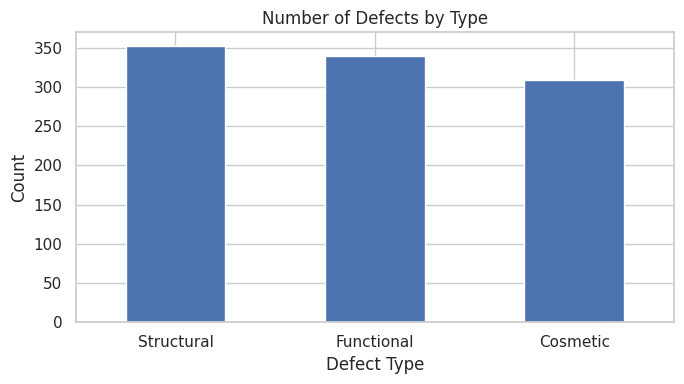

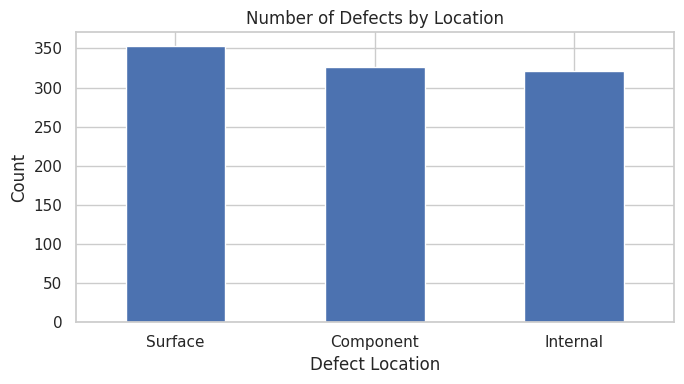

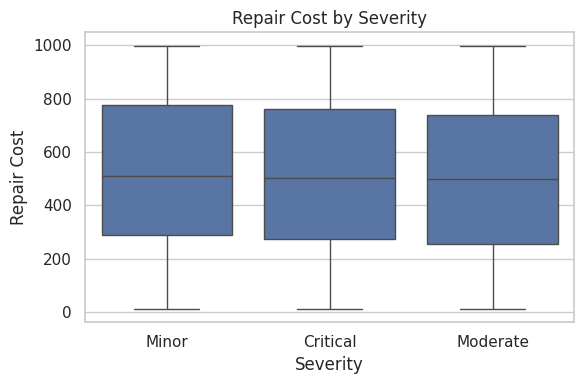

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# 1. Defects by type
plt.figure(figsize=(7,4))
df['defect_type'].value_counts().plot(kind='bar')
plt.title('Number of Defects by Type')
plt.xlabel('Defect Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. Defects by location
plt.figure(figsize=(7,4))
df['defect_location'].value_counts().plot(kind='bar')
plt.title('Number of Defects by Location')
plt.xlabel('Defect Location')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 3. Repair cost by severity
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='severity', y='repair_cost')
plt.title('Repair Cost by Severity')
plt.xlabel('Severity')
plt.ylabel('Repair Cost')
plt.tight_layout()
plt.show()


In [24]:

threshold = df['repair_cost'].quantile(0.75)
df['high_cost'] = (df['repair_cost'] > threshold).astype(int)

print('High-cost threshold:', threshold)
print('High-cost proportion:', df['high_cost'].mean())



High-cost threshold: 759.0649999999999
High-cost proportion: 0.25


In [25]:
features = ['product_id', 'defect_type', 'defect_location',
            'severity', 'inspection_method', 'month', 'day_of_week']

df_ml = pd.get_dummies(df[features + ['high_cost']], drop_first=True)

X = df_ml.drop('high_cost', axis=1)
y = df_ml['high_cost']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape



((800, 16), (200, 16))

In [26]:


rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced',
    min_samples_leaf=2
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification report:")
print(classification_report(y_test, y_pred))



Confusion matrix:
[[136  14]
 [ 47   3]]

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.91      0.82       150
           1       0.18      0.06      0.09        50

    accuracy                           0.69       200
   macro avg       0.46      0.48      0.45       200
weighted avg       0.60      0.69      0.64       200



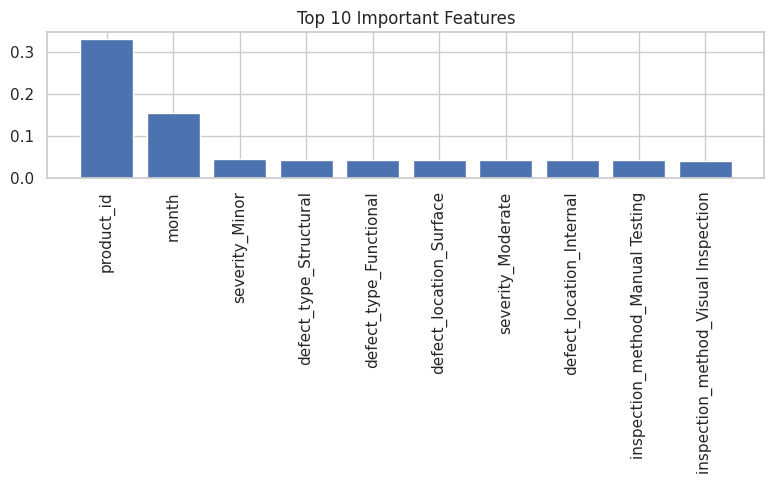

In [27]:


importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.title("Top 10 Important Features")
plt.bar(range(10), importances[indices][:10], align='center')
plt.xticks(range(10), X.columns[indices][:10], rotation=90)
plt.tight_layout()
plt.show()
